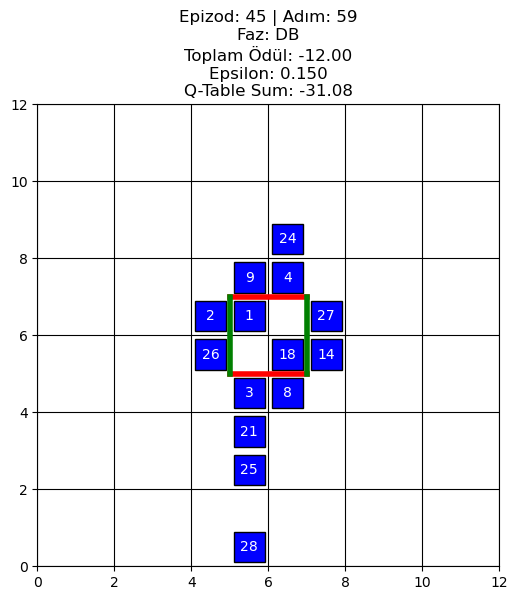

Epizod=45, Adım=59, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=0, Faz=0, Ödül=-8, Toplam=-8.00
Epizod=46, Adım=1, Faz=1, Ödül=-4, Toplam=-12.00
Epizod=46, Adım=2, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=3, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=4, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=5, Faz=1, Ödül=0, Toplam=-12.00
Epizod=46, Adım=6, Faz=1, Ödül=0, Toplam=-12.00
Epizod=46, Adım=7, Faz=1, Ödül=0, Toplam=-12.00
Epizod=46, Adım=8, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=9, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=10, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=11, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=12, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=13, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=14, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=15, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=16, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=17, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=18, Faz=0, Ödül=0, Toplam=-12.00
Epizod=46, Adım=19, Faz=0, Öd

In [2]:
import numpy as np                   # Sayısal işlem kütüphanesi
import random                        # Rastgele seçimler için
import matplotlib.pyplot as plt      # Görselleştirme için
from matplotlib import patches        # Araçları kutucuk olarak çizmek için
from IPython.display import clear_output, display  # Notebook görüntü güncelleme

# =====================================================
#   TRAFİK ORTAMI (ÇEVRE) SINIFI
# =====================================================
class TrafikOrtamQLight:
    def __init__(self):
        self.grid_boyut = 12                 # Yol 12x12 grid
        self.max_kuyruk = 10                 # Q-table boyutu sınırı
        self.arac_sayac = 0                  # Araç ID sayacı
        self.faz = 0                         # 0: Doğu-Batı yeşil, 1: Kuzey-Güney yeşil
        self.araclar = {}                    # Aktif araçlar {id: (x,y)}
        self.kuyruk_db = [3,3]               # Doğu-Batı yönlerinde kuyruk
        self.kuyruk_kg = [3,3]               # Kuzey-Güney kuyruk

        # ---------------- Q TABLE --------------------
        self.q_table = np.zeros(
            (self.max_kuyruk+1, self.max_kuyruk+1,
             self.max_kuyruk+1, self.max_kuyruk+1, 2)
        )

        # ----------- Q-LEARNING PARAMETRELERİ --------
        self.alpha = 0.25     # Öğrenme oranı
        self.gamma = 0.90     # Geleceğin ödül katsayısı
        self.epsilon = 0.15   # Epsilon-greedy keşif oranı

        self.toplam_odul = 0  # Epizod toplam ödülü

    # Durumu 4 sayılık tuple yapıyoruz (Q-table indekslemek için)
    def _durum_tuple(self):
        return (
            min(self.kuyruk_db[0], self.max_kuyruk),
            min(self.kuyruk_db[1], self.max_kuyruk),
            min(self.kuyruk_kg[0], self.max_kuyruk),
            min(self.kuyruk_kg[1], self.max_kuyruk)
        )

    # Ortamı yeniden başlat
    def reset(self):
        self.kuyruk_db = [3,3]
        self.kuyruk_kg = [3,3]
        self.faz = 0
        self.arac_sayac = 0
        self.araclar.clear()
        self.toplam_odul = 0
        return self._durum_tuple()

    # -----------------------------------------------------
    #   STEP: Bir eylem uygular ve ortamı 1 adım ilerletir
    # -----------------------------------------------------
    def step(self, eylem):

        self.faz = eylem  # Ajanın seçtiği ışık fazı

        yeni_positions = {}
        kavsak_icerisi = set()

        # ------------------------------
        #   ARAÇ SPAWN (Girişlerden)
        # ------------------------------
        if len(self.araclar) < 12:
            girisler = [(0,5), (11,6), (5,0), (6,11)]
            for gx, gy in girisler:
                if random.random() < 0.3:
                    self.arac_sayac += 1
                    if (gx,gy) not in self.araclar.values():
                        self.araclar[self.arac_sayac] = (gx,gy)

        # --------------------------------
        #   ARAÇ HAREKETİ
        # --------------------------------
        for aid, (x,y) in self.araclar.items():

            nx, ny = x, y  # Yeni konum

            # ---- DOĞU-BATI YOLU ----
            if y in [5,6]:

                if self.faz == 0:  # DB yeşil
                    if x < 5: nx += 1
                    elif x > 6: nx -= 1
                    elif 5 <= x <= 6:    # Kavşak geçişi
                        if y == 5: nx = 7
                        if y == 6: nx = 4

            # ---- KUZEY-GÜNEY YOLU ----
            if x in [5,6]:

                if self.faz == 1:  # KG yeşil
                    if y < 5: ny += 1
                    elif y > 6: ny -= 1
                    elif 5 <= y <= 6:
                        if x == 5: ny = 7
                        if x == 6: ny = 4

            # Çarpışma önleme
            if (nx,ny) not in kavsak_icerisi:
                yeni_positions[aid] = (nx,ny)
                kavsak_icerisi.add((nx,ny))

        self.araclar = yeni_positions

        # Kuyrukların azalması
        self.kuyruk_db = [max(k-1,0) for k in self.kuyruk_db]
        self.kuyruk_kg = [max(k-1,0) for k in self.kuyruk_kg]

        # Ödül hesaplama
        odul = -(sum(self.kuyruk_db) + sum(self.kuyruk_kg))
        self.toplam_odul += odul

        # Senaryo bitiş koşulu
        done = max(self.kuyruk_db + self.kuyruk_kg) > 20

        return self._durum_tuple(), odul, done

    # -------------------------------------
    #   EPSILON-GREEDY EYLEM SEÇİMİ
    # -------------------------------------
    def eylem_sec(self, durum):

        if random.random() < self.epsilon:
            return random.choice([0,1])          # Keşif
        else:
            return np.argmax(self.q_table[durum]) # En iyi eylem

    # -------------------------------------
    #   Q ÖĞRENME GÜNCELLEMESİ
    # -------------------------------------
    def q_guncelle(self, durum, eylem, odul, yeni_durum):

        mevcut_q = self.q_table[durum][eylem]
        en_iyi_yeni = np.max(self.q_table[yeni_durum])

        yeni_q = mevcut_q + self.alpha * (odul + self.gamma * en_iyi_yeni - mevcut_q)

        self.q_table[durum][eylem] = yeni_q

    # ----------------------------------------------------------
    #   GÖRSELLEŞTİRME (JUPYTER NOTEBOOK CANLI ANİMASYON)
    # ----------------------------------------------------------
    def render_notebook(self, epizod=None, adim=None):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0, self.grid_boyut)
        ax.set_ylim(0, self.grid_boyut)
        ax.set_aspect('equal')

        # Araçları çiz
        for aid,(x,y) in self.araclar.items():
            ax.add_patch(
                patches.Rectangle((x+0.1,y+0.1), 0.8,0.8, facecolor='blue', edgecolor='black')
            )
            ax.text(x+0.5, y+0.5, str(aid), ha='center', va='center', color='white')

        # Kavşak alanı
        ax.add_patch(patches.Rectangle((5,5),2,2, fill=False, edgecolor='black', linewidth=2))

        # Trafik ışıkları
        ax.plot([5,7],[5,5], color='green' if self.faz==1 else 'red', linewidth=4)
        ax.plot([5,7],[7,7], color='green' if self.faz==1 else 'red', linewidth=4)
        ax.plot([5,5],[5,7], color='green' if self.faz==0 else 'red', linewidth=4)
        ax.plot([7,7],[5,7], color='green' if self.faz==0 else 'red', linewidth=4)

        # Grid çizgileri
        ax.grid(True, color='black')

        # Bilgi paneli
        ax.set_title(
            f"Epizod: {epizod} | Adım: {adim}\n"
            f"Faz: {'DB' if self.faz==0 else 'KG'}\n"
            f"Toplam Ödül: {self.toplam_odul:.2f}\n"
            f"Epsilon: {self.epsilon:.3f}\n"
            f"Q-Table Sum: {np.sum(self.q_table):.2f}"
        )

        display(fig)
        plt.close()


# =====================================================
#   Q-LEARNING EĞİTİM DÖNGÜSÜ
# =====================================================
env = TrafikOrtamQLight()

epizod_sayisi = 50        # Epizod sayısı
adim_sayisi = 60          # Her epizod adım sayısı

for ep in range(epizod_sayisi):

    durum = env.reset()

    for adim in range(adim_sayisi):

        # --- EPSILON-GREEDY EYLEM ---
        eylem = env.eylem_sec(durum)

        # --- STEP ---
        yeni_durum, odul, done = env.step(eylem)

        # --- Q GÜNCELLEME ---
        env.q_guncelle(durum, eylem, odul, yeni_durum)

        # --- DURUMU GÜNCELLE ---
        durum = yeni_durum

        # --- GÖRSELLEŞTİRME ---
        if ep % 5 == 0:  # Her 5 epizotta animasyon göster
            env.render_notebook(epizod=ep, adim=adim)

        # --- KONSOLA BİLGİ YAZDIR ---
        print(f"Epizod={ep}, Adım={adim}, Faz={eylem}, Ödül={odul}, Toplam={env.toplam_odul:.2f}")

        if done:
            break

print("\nEĞİTİM TAMAMLANDI! 🚦")
